# Preprocessing

---
## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

from utils.duplicates import remove_rows, get_duplicates_to_delete, visualize_duplicates
from utils.tensorflow_preprocessing import prepare_image_dataset, show_batch
from utils.encoding import one_hot_encode, label_encode

In [ ]:
df = pd.read_csv('../data/processed/csv/df.csv')
duplicates = pd.read_csv('../data/processed/csv/duplicates.csv')

--- 
## Remove duplicates

2 DataFrames will be outputted:

| Variables   | Description                                                       |
|-------------|-------------------------------------------------------------------|
| `df_no_dup` | DataFrame with all but one duplicates of each style removed       |
| `df_no_ins` | DataFrame with misclassified images manually reviewed and removed |

### Automatically delete:
- For each duplicate group, delete all but one rows marked as "Duplicate" for each "Style".
- Outputs "df_no_dup".

In [ ]:
duplicates_to_delete = get_duplicates_to_delete(duplicates)
df_no_dup = remove_rows(df, duplicates_to_delete)
df_no_dup

### Manually delete:
- Any rows marked as "Inspect" that belongs in the wrong "Class".
- Outputs "df_no_ins"

In [ ]:
inspects = duplicates[duplicates['Duplicate_Type'] == 'Inspect']
inspects

In [ ]:
total_inspect_groups = inspects["Group"].nunique(dropna=False)

In [ ]:
inspects_rows_to_delete = [91, 154, 205, 227, 235, 277, 280, 281, 287, 290, 299, 310, 318, 323, 325]

In [ ]:
inspect_review = inspects.copy()
inspect_review["Duplicate_Type"] = "Keep"
# inspect_review.loc[inspects_rows_to_delete, "Duplicate_Type"] = "DELETE"

In [ ]:
visualize_duplicates(inspect_review, total_inspect_groups)

In [ ]:
inspects_to_delete = inspect_review[inspect_review["Duplicate_Type"] == "DELETE"]
inspects_to_delete

In [ ]:
df_no_ins = remove_rows(df, inspects_to_delete)
df_no_ins

---
## Split (train, validation, test)

This part is complicated since there are 2 starting DataFrames (duplicates cleaned / inspects cleaned), and 2 target classes (Class / Style). 
Please refer to this table for the variables after splitting.

#### Duplicates cleaned
| Train                  | Validation           | Test                  | Description   |
|------------------------|----------------------|-----------------------|---------------|
| `no_dup_train_X`       | `no_dup_val_X`       | `no_dup_test_X`       | Data features |
| `no_dup_train_Y_class` | `no_dup_val_Y_class` | `no_dup_test_Y_class` | Target class  |
| `no_dup_train_Y_style` | `no_dup_val_Y_style` | `no_dup_test_Y_style` | Target style  |

#### Manual inspection cleaned
| Train                  | Validation           | Test                  | Description   |
|------------------------|----------------------|-----------------------|---------------|
| `no_ins_train_X`       | `no_ins_val_X`       | `no_ins_test_X`       | Data features |
| `no_ins_train_Y_class` | `no_ins_val_Y_class` | `no_ins_test_Y_class` | Target class  |
| `no_ins_train_Y_style` | `no_ins_val_Y_style` | `no_ins_test_Y_style` | Target style  |


### Prepare target and training

In [ ]:
# df_no_dup
df_no_dup_target_class = df_no_dup[["Class"]].copy()
df_no_dup_target_style = df_no_dup[["Style"]].copy()

# df_no_ins
df_no_ins_target_class = df_no_ins[["Class"]].copy()
df_no_ins_target_style = df_no_ins[["Style"]].copy()

In [ ]:
# Currently dropping all but "Path", since the values of all the other columns ("Type", "Width", "Height"...) is the same
columns_to_keep = ["Path"] # Change later if needed
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]

df_no_dup_train = df_no_dup.drop(columns=columns_to_drop, axis=1)
df_no_ins_train = df_no_ins.drop(columns=columns_to_drop, axis=1)

### Splitting

In [ ]:
# df_no_dup
no_dup_train_X, no_dup_test_X, no_dup_train_Y_class, no_dup_test_Y_class, no_dup_train_Y_style, no_dup_test_Y_style = train_test_split(
    df_no_dup_train,
    df_no_dup_target_class,
    df_no_dup_target_style,
    test_size=0.2,
    random_state=42
)
no_dup_train_X, no_dup_val_X, no_dup_train_Y_class, no_dup_val_Y_class, no_dup_train_Y_style, no_dup_val_Y_style = train_test_split(
    no_dup_train_X,
    no_dup_train_Y_class,
    no_dup_train_Y_style,
    test_size=0.25,
    random_state=42
)

# df_no_ins
no_ins_train_X, no_ins_test_X, no_ins_train_Y_class, no_ins_test_Y_class, no_ins_train_Y_style, no_ins_test_Y_style = train_test_split(
    df_no_ins_train,
    df_no_ins_target_class,
    df_no_ins_target_style,
    test_size=0.2,
    random_state=42
)
no_ins_train_X, no_ins_val_X, no_ins_train_Y_class, no_ins_val_Y_class, no_ins_train_Y_style, no_ins_val_Y_style = train_test_split(
    no_ins_train_X,
    no_ins_train_Y_class,
    no_ins_train_Y_style,
    test_size=0.25,
    random_state=42
)

Note: please refer to the tables under "Split (train, validation, test)" for easier understanding

---
## Rescaling & Normalization
Note: Using Tensorflow for quick normalization and rescaling. In 'utils/tensorflow_preprocessing.py' file, there is a functions to normalize and rescale the each image in the dataset.

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

In [1]:
import pandas as pd
import tensorflow as tf
from utils.duplicates import remove_rows, get_duplicates_to_delete, visualize_duplicates
from utils.tensorflow_preprocessing import prepare_image_dataset, show_batch

df = pd.read_csv('../data/processed/csv/df.csv')
duplicates = pd.read_csv('../data/processed/csv/duplicates.csv')
dup_df = get_duplicates_to_delete(duplicates)
dup_paths = dup_df['Path']
df['Augment'] = df['Path'].isin(dup_paths)

Identifying rows to delete...


100%|██████████| 5684/5684 [00:05<00:00, 1027.51it/s]


In [2]:
base_path = '../data/raw/Furniture_Data'

# dup_train_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
# dup_train_generator = prepare_image_dataset(image_paths, 256, 256, 32, dup_train_datagen, base_path)

In [ ]:
# dup_val_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
# dup_val_generator = prepare_image_dataset(image_paths, 256, 256, 32, dup_val_datagen, base_path)

In [ ]:
# dup_test_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
# dup_test_generator = prepare_image_dataset(image_paths, 256, 256, 32, dup_test_datagen, base_path)

In [2]:
# ins_train_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
base_path = '../data/raw/Furniture_Data'
ins_train_generator = prepare_image_dataset(df, 256, 256, 32, base_path)

In [3]:
from matplotlib import pyplot as plt

base_path = '../data/raw/Furniture_Data'

for batch in ins_train_generator.take(1):
    images = batch  # This assumes that the batch directly contains images

# Check the shape of the batch of images
print("Batch shape:", images.shape)

Batch shape: (32, 256, 256, 3)


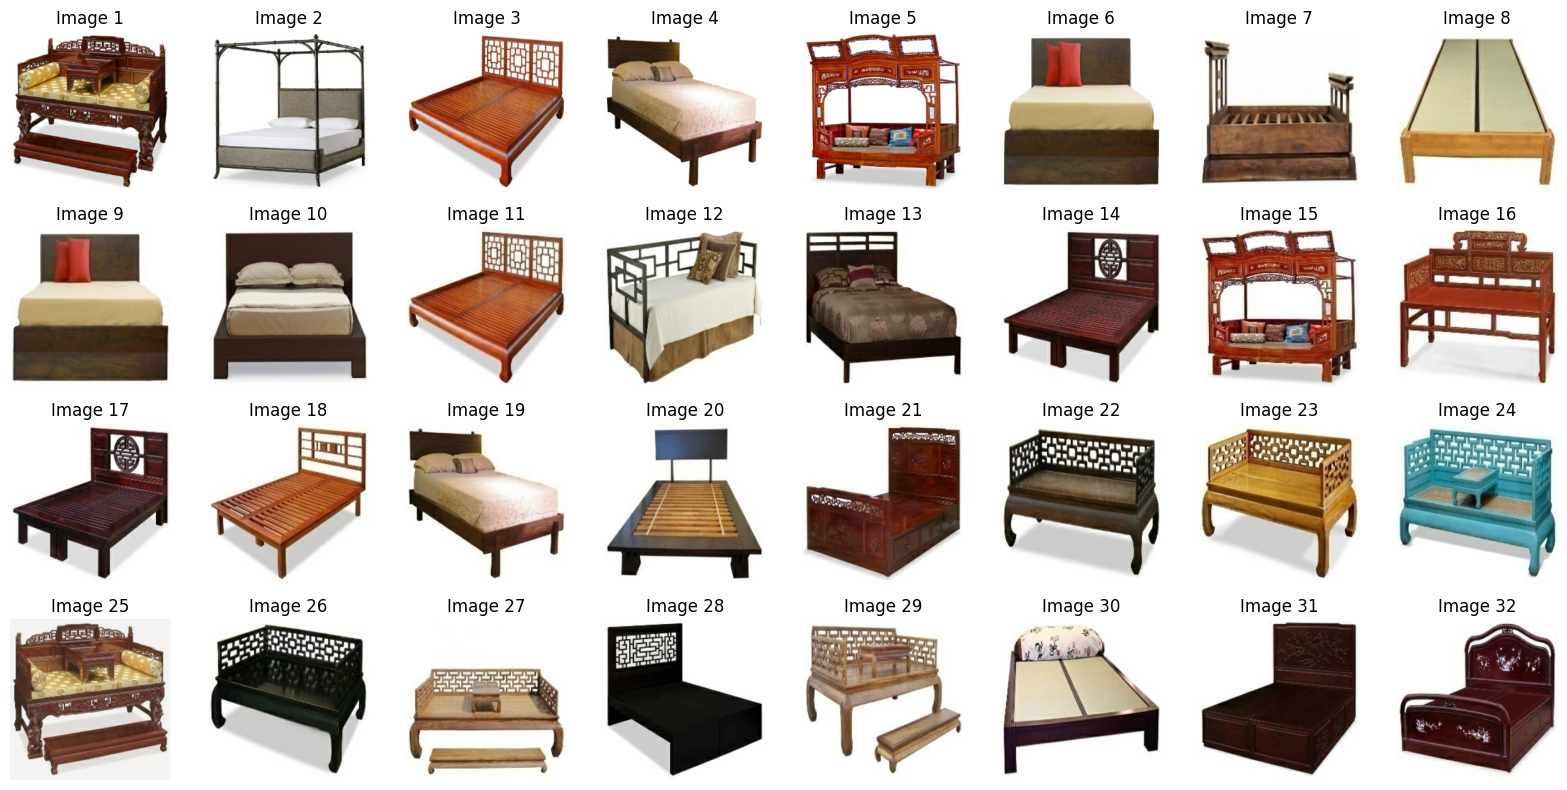

In [4]:
batch_size = images.shape[0]  # Get the batch size
fig, axs = plt.subplots(4, 8, figsize=(16, 8))  # Create a grid of subplots (4 rows, 8 columns)
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array

for i in range(batch_size):
    image = images[i]  # Select the i-th image from the batch
    image_np = image.numpy().astype('uint8')  # Convert TensorFlow tensor to NumPy array for plotting
    ax = axs[i]  # Select the corresponding subplot
    ax.imshow(image_np)  # Display the image
    ax.axis('off')  # Hide axis
    ax.set_title(f"Image {i+1}")  # Set subplot title

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

In [ ]:
# ins_val_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
# ins_val_generator = prepare_image_dataset(image_paths, 256, 256, 32, ins_val_datagen, base_path)

In [ ]:
# ins_test_datagen = create_image_data_generator()
# image_paths = no_dup_train_X['Path'].tolist()
# ins_test_generator = prepare_image_dataset(image_paths, 256, 256, 32, ins_test_datagen, base_path)

---
### Testing code to check if the images are clearly normalized (Can delete after checking)

In [ ]:
# Visualize the first batch in dup_train_generator
for image_batch, path_batch in dup_train_generator.take(1):
    show_batch(image_batch.numpy(), path_batch.numpy().astype(str))

In [ ]:
# Extract the first batch
# for images, _ in dup_train_generator.take(1):
#     images = images.numpy()  # Convert Tensor to NumPy array
# 
#     # Find positions of pixels in the first image that are neither 0 nor 1
#     non_binary_pixels = np.where((images[0] != 0) & (images[0] != 1))
# 
#     # Print the positions of these non-binary pixels
#     print("Non-binary pixel positions (y, x, channel):")
#     for y, x, c in zip(*non_binary_pixels):
#         print(f"Position ({y}, {x}, {c}) with value {images[0][y][x][c]}")

---
## Augmentation

In [ ]:
# ins_train_generator

---
## Encoding

In [ ]:
# One-Hot Encoding
no_dup_train_Y_style = one_hot_encode(no_dup_train_Y_style, 'Style')
no_dup_test_Y_style = one_hot_encode(no_dup_test_Y_style, 'Style')
no_dup_val_Y_style = one_hot_encode(no_dup_val_Y_style, 'Style')

no_ins_train_Y_style = one_hot_encode(no_ins_train_Y_style, 'Style')
no_ins_test_Y_style = one_hot_encode(no_ins_test_Y_style, 'Style')
no_ins_val_Y_style = one_hot_encode(no_ins_val_Y_style, 'Style')

# Label Encoding
no_dup_train_Y_class = label_encode(no_dup_train_Y_class, 'Class')
no_dup_test_Y_class = label_encode(no_dup_test_Y_class, 'Class')
no_dup_val_Y_class = label_encode(no_dup_val_Y_class, 'Class')

no_ins_train_Y_class = label_encode(no_ins_train_Y_class, 'Class')
no_ins_test_Y_class = label_encode(no_ins_test_Y_class, 'Class')
no_ins_val_Y_class = label_encode(no_ins_val_Y_class, 'Class')

In [ ]:
no_dup_train_Y_style.head()

In [ ]:
no_dup_train_Y_class.head()

---
## Saving the images